# COMP579 Assignment 2

**Coding: Tabular RL [70 points]**

## Question 1

In [2]:
# This notebook was ran locally with Python==3.11.7 and gym==0.25.2
# Experiments take less than 1 hour on a M1 Macbook Air, including the bonus question

import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # for progress bar

In [3]:
def softmax(x:list[int], temp:float):
  x_adj = x - np.max(x)

  exp_x = np.exp(x_adj / temp)
  sum_exp_x = np.sum(exp_x)
  return exp_x / sum_exp_x

In [4]:
class Sarsa:
  def __init__(self, env, alpha, gamma, temp):
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.temp = temp
    self.Q = np.zeros((env.observation_space.n, env.action_space.n)) # state-action value table

  def select_action(self, s, greedy=False) -> int:
    action_values = self.Q[s]

    optimal_action = np.argmax(action_values)
    policy_action = np.random.choice(self.env.action_space.n, p=softmax(action_values, self.temp))

    return optimal_action if greedy else policy_action

  def update(self, s, a, r, s_prime, a_prime, done) -> None:
    target = r if done else r + self.gamma * self.Q[s_prime][a_prime]
    self.Q[s][a] = self.Q[s][a] + self.alpha * (target - self.Q[s][a])

  def name(self) -> str:
    return "SARSA"


class ExpectedSarsa(Sarsa):
  def update(self, s, a, r, s_prime, a_prime, done) -> None:
    actions = self.Q[s_prime]
    action_probs = softmax(actions, self.temp)

    target = r if done else r + self.gamma * sum([action * prob for action, prob in zip(actions, action_probs)])
    self.Q[s][a] = self.Q[s][a] + self.alpha * (target - self.Q[s][a])

  def name(self) -> str:
    return "exp SARSA"

# bonus question, optional
class Hybrid_Sarsa_Q(Sarsa):
  def __init__(self, env, alpha, gamma, temp, theta):
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.temp = temp
    self.theta = theta # denoted as alpha in the assignment instruction
    self.Q = np.zeros((env.observation_space.n, env.action_space.n)) # state-action value table

  def update(self, s, a, r, s_prime, a_prime, done):
    actions = self.Q[s_prime]
    action_probs = softmax(actions, self.temp)

    q_learning_target = np.max(actions)
    expected_sarsa_target = sum([action * prob for action, prob in zip(actions, action_probs)])

    target = r if done else r + self.gamma * ((1-self.theta) * q_learning_target + (self.theta) * expected_sarsa_target)
    self.Q[s][a] = self.Q[s][a] + self.alpha * (target - self.Q[s][a])

## Experiment

In [6]:
env_name = 'Taxi-v3'
env = gym.make(env_name)

In [7]:
NUM_TRIALS = 10
NUM_SEGMENTS = 500
NUM_EXPLORE = 10
NUM_TEST = 1
      
temperatures = [0.1, 0.5, 0.9] # The higher the temp, the more exploration from the policy
alphas = [0.1, 0.4, 0.7]

gamma = 1

def experiment(agent:Sarsa):
  """
  Run an experiment with an agent and the pre-defined number of trials, segments,
  etc.

  Return the mean return of the last NUM_EXPLORE training episodes and
  NUM_TEST test episodes averaged over NUM_TRIAL Strials. Also returns the
  max and min returns throughout the last episodes to measure uncertainty. 

  Also returns the average reward on every test run amongst all trials.
  """

  experiment_train_results, experiment_test_results = [], []
  min_explore_return, max_explore_return = float('inf'), -float('inf')
  min_test_return, max_test_return = float('inf'), -float('inf')

  all_test_return = []

  with tqdm(total=NUM_TRIALS * NUM_SEGMENTS * (NUM_EXPLORE + NUM_TEST)) as pbar:

    for trial in range(NUM_TRIALS):
      trial_train_results, trial_test_results = list(), list()

      trial_test_return = np.zeros(NUM_SEGMENTS)

      for segment in range(NUM_SEGMENTS):
        is_last_segment = (segment + 1 == NUM_SEGMENTS)

        for exploration_ep in range(NUM_EXPLORE):
          state = agent.env.reset()

          exploration_return = 0
          step = 0

          is_terminal = False
          while not is_terminal:
            action = agent.select_action(state)

            next_state, reward, is_terminal, _ = agent.env.step(action)
            next_action = agent.select_action(next_state)

            exploration_return += gamma ** step * reward

            agent.update(state, \
                        action, \
                        reward, \
                        next_state, \
                        next_action, \
                        is_terminal)

            state, action = next_state, next_action

            step += 1

          if is_last_segment:
            trial_train_results.append(exploration_return)

            min_explore_return = min(min_explore_return, \
                                     exploration_return)
            max_explore_return = max(max_explore_return, \
                                     exploration_return)

          pbar.update(1)

        for test_ep in range(NUM_TEST):
          state = agent.env.reset()

          test_return = 0
          step = 0

          is_terminal = False
          while not is_terminal:
            action = agent.select_action(state, greedy=True)

            next_state, reward, is_terminal, _ = agent.env.step(action)
            next_action = agent.select_action(next_state)

            test_return += gamma ** step * reward

            state, action = next_state, next_action

            step += 1

          trial_test_return[segment] = test_return

          if is_last_segment:
            trial_test_results.append(test_return)

            min_test_return = min(min_test_return, \
                                     test_return)
            max_test_return = max(max_test_return, \
                                     test_return)

          pbar.update(1)

        if is_last_segment:
          experiment_train_results.append(np.mean(trial_train_results))
          experiment_test_results.append(np.mean(trial_test_results))

      all_test_return.append(trial_test_return)

  return np.mean(experiment_train_results), \
         np.mean(experiment_test_results), \
         min_explore_return, \
         max_explore_return, \
         min_test_return, \
         max_test_return, \
         np.mean(all_test_return, axis=0)

running agent SARSA with params temp = 0.1, alpha = 0.1


  0%|          | 0/55000 [00:00<?, ?it/s]

100%|██████████| 55000/55000 [00:27<00:00, 2011.81it/s]


running agent SARSA with params temp = 0.1, alpha = 0.4


100%|██████████| 55000/55000 [00:24<00:00, 2204.31it/s]


running agent SARSA with params temp = 0.1, alpha = 0.7


100%|██████████| 55000/55000 [00:24<00:00, 2212.79it/s]


running agent SARSA with params temp = 0.5, alpha = 0.1


100%|██████████| 55000/55000 [00:30<00:00, 1822.08it/s]


running agent SARSA with params temp = 0.5, alpha = 0.4


100%|██████████| 55000/55000 [00:26<00:00, 2075.88it/s]


running agent SARSA with params temp = 0.5, alpha = 0.7


100%|██████████| 55000/55000 [00:27<00:00, 2005.56it/s]


running agent SARSA with params temp = 0.9, alpha = 0.1


100%|██████████| 55000/55000 [00:31<00:00, 1730.72it/s]


running agent SARSA with params temp = 0.9, alpha = 0.4


100%|██████████| 55000/55000 [00:27<00:00, 2006.20it/s]


running agent SARSA with params temp = 0.9, alpha = 0.7


100%|██████████| 55000/55000 [00:26<00:00, 2070.82it/s]


running agent exp SARSA with params temp = 0.1, alpha = 0.1


100%|██████████| 55000/55000 [00:32<00:00, 1683.57it/s]


running agent exp SARSA with params temp = 0.1, alpha = 0.4


100%|██████████| 55000/55000 [00:30<00:00, 1821.89it/s]


running agent exp SARSA with params temp = 0.1, alpha = 0.7


100%|██████████| 55000/55000 [00:30<00:00, 1787.48it/s]


running agent exp SARSA with params temp = 0.5, alpha = 0.1


100%|██████████| 55000/55000 [00:33<00:00, 1625.45it/s]


running agent exp SARSA with params temp = 0.5, alpha = 0.4


100%|██████████| 55000/55000 [00:30<00:00, 1777.47it/s]


running agent exp SARSA with params temp = 0.5, alpha = 0.7


100%|██████████| 55000/55000 [00:31<00:00, 1767.02it/s]


running agent exp SARSA with params temp = 0.9, alpha = 0.1


100%|██████████| 55000/55000 [00:39<00:00, 1395.68it/s]


running agent exp SARSA with params temp = 0.9, alpha = 0.4


100%|██████████| 55000/55000 [00:30<00:00, 1777.05it/s]


running agent exp SARSA with params temp = 0.9, alpha = 0.7


100%|██████████| 55000/55000 [00:30<00:00, 1791.71it/s]


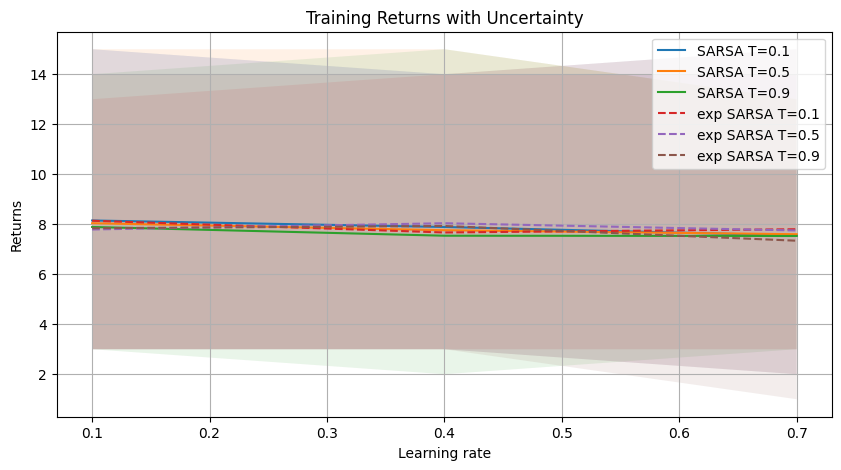

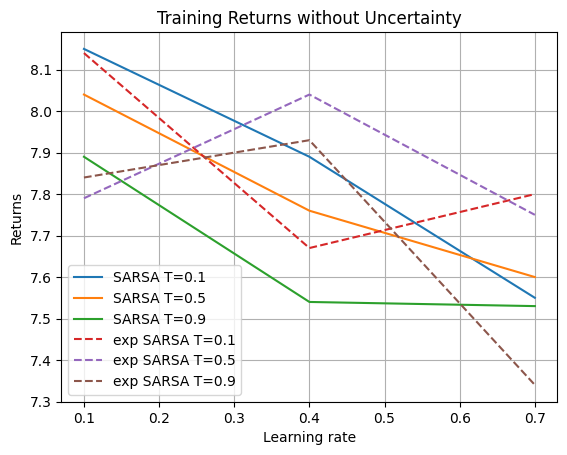

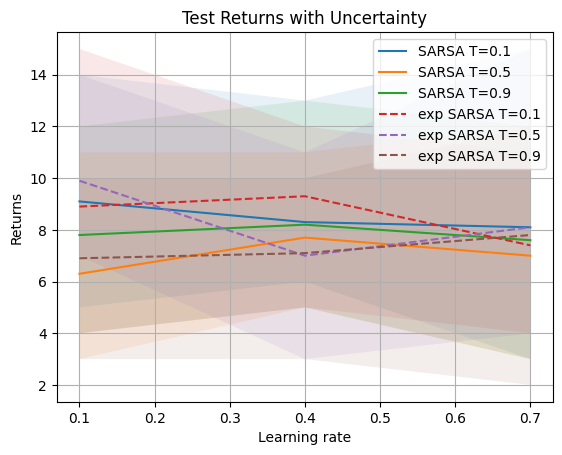

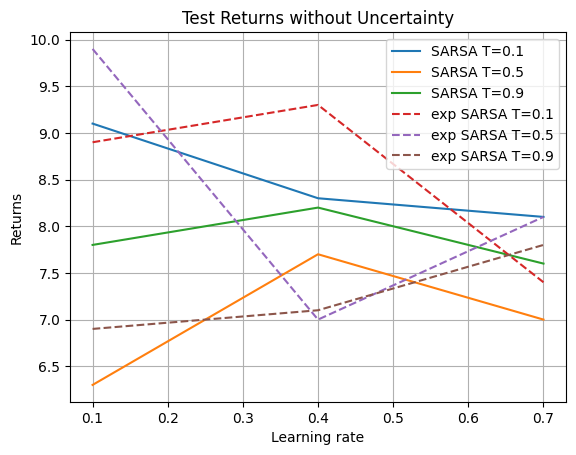

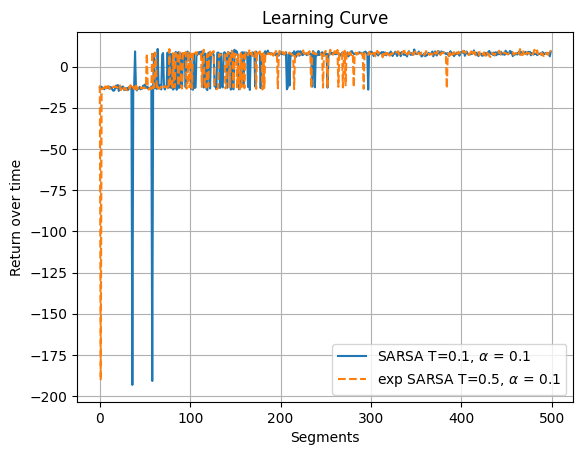

In [26]:
plt.figure(figsize=(10, 5))

algos: list[Sarsa] = [Sarsa, ExpectedSarsa]

best_exp_sarsa_return: tuple[float, float, float, list[float]] = (None, None, -float('inf'), []) # alpha, temperature, result, learning_curve
best_sarsa_return: tuple[float, float, float, list[float]] = (None, None, -float('inf'), [])     # alpha, temperature, result, learning_curve

for algo in algos:
  for t in temperatures:

    exploration_result = []
    test_result = []

    min_return_during_explore = []
    max_return_during_explore = []
    min_return_during_test = []
    max_return_during_test = []

    for a in alphas:

      agent = algo(env, a, gamma, t)

      print(f"running agent {agent.name()} with params temp = {t}, alpha = {a}")

      exp_results = experiment(agent)

      exploration_result.append(exp_results[0])
      test_result.append(exp_results[1])

      min_return_during_explore.append(exp_results[2])
      max_return_during_explore.append(exp_results[3])

      min_return_during_test.append(exp_results[4])
      max_return_during_test.append(exp_results[5])

      learning_curve = exp_results[6]

      # check if the run is the new best, for plotting learning curve later
      match agent.name():
        case "SARSA":
          if exp_results[1] > best_sarsa_return[2]:
            best_sarsa_return = (a,t,exp_results[1], learning_curve)

        case "exp SARSA":
          if exp_results[1] > best_exp_sarsa_return[2]:
            best_exp_sarsa_return = (a,t,exp_results[1], learning_curve)

    plt.figure(1)
    plt.plot(alphas, exploration_result, label=f"{agent.name()} T={t}", linestyle='--' if agent.name() == 'exp SARSA'else None)

    plt.fill_between(alphas, \
                     min_return_during_explore, \
                     max_return_during_explore, \
                     alpha=0.1)  # Uncertainty shading

    plt.figure(2)
    plt.plot(alphas, exploration_result, label=f"{agent.name()} T={t}", linestyle='--' if agent.name() == 'exp SARSA'else None)

    plt.figure(3)
    plt.plot(alphas, test_result, label=f"{agent.name()} T={t}", linestyle='--' if agent.name() == 'exp SARSA'else None)
    plt.fill_between(alphas, \
                     min_return_during_test, \
                     max_return_during_test, \
                     alpha=0.1)  # Uncertainty shading

    plt.figure(4)
    plt.plot(alphas, test_result, label=f"{agent.name()} T={t}", linestyle='--' if agent.name() == 'exp SARSA'else None)


# plot the best performing runs' learning curves (test results) 
plt.figure(5)
plt.plot(range(NUM_SEGMENTS), best_sarsa_return[3], label=f"SARSA T={best_sarsa_return[1]}, $\\alpha$ = {best_sarsa_return[0]}")
plt.plot(range(NUM_SEGMENTS), best_exp_sarsa_return[3], label=f"exp SARSA T={best_exp_sarsa_return[1]}, $\\alpha$ = {best_exp_sarsa_return[0]}", linestyle='--')


# show graphs
plt.figure(1)
plt.legend()
plt.title("Training Returns with Uncertainty")
plt.xlabel("Learning rate")
plt.ylabel("Returns")
plt.grid(True)

plt.figure(2)
plt.legend()
plt.title("Training Returns without Uncertainty")
plt.xlabel("Learning rate")
plt.ylabel("Returns")
plt.grid(True)

plt.figure(3)
plt.legend()
plt.title("Test Returns with Uncertainty")
plt.xlabel("Learning rate")
plt.ylabel("Returns")
plt.grid(True)

plt.figure(4)
plt.legend()
plt.title("Test Returns without Uncertainty")
plt.xlabel("Learning rate")
plt.ylabel("Returns")
plt.grid(True)

plt.figure(5)
plt.legend()
plt.title("Learning Curve")
plt.xlabel("Segments")
plt.ylabel("Return over time")
plt.grid(True)

## Results

We observe in the experiments that the returns generally revolve le around the same point. For training return, it revolves around 8 with minimal variances, and for testing returns, the average return has a larger variance, peaking at around 9 with good hyperparameter and model combinations, but also reaches as low as 6. We also observe slightly less uncertainty for testing returns. Note that $\gamma$ was set to $1$ because the episodes are finite and steps are already punitive (-1 reward) by default.

In closed-up graphs (i.e. return graphs that do not show uncertaintt), we see very minimal effects from the learning rate to returns observed; the plots were patternless. We do note that exected SARSA obtained a better test return compared to normal SARSA.

The best parameters were determined from the highest average test return. For SARSA and expected SARSA, the best parameters are respectively $T = 0.001, \alpha = 0.1$ and $T = 0.001, \alpha = 0.7$, for which we plotted the learning curve with. It is important to note that they only performed slightly better than other parameter combinations, hence the significance of this result is low.

From the learning curve graph, we see no issue of adaptation from the two learning algorithms. We observe earlier segments to sometimes average returns between $-175$ and $-200$ due to the time limit of 200 steps. Most of the average return during the learning phase was around $< -20$, and stabilized in the positive before in the $300^\text{th}$ segments. 

## Discussion
From the models' performance on the taxi problem, the results indicate that both algorithms are capable of learning effective policies for the task, as evidenced by the converging returns over time. Expected SARSA outperformed normal SARSA in convergence speed and test returns.

The learning curves showed rapid convergence to stable policies through early segments' dramatic increase in returns from significantly negative values to stable positive returns before the 100th segment; suggesting that both SARSA and exp SARSA can quickly adapt and improve their strategies in the early stages of learning.

After testing a wide range of temperatures and learning rates, the results do not appear to imply an effect from the temperature or learning rate on the cumulatie return. All experiments were able to converge to approximately the same return throughout the learning. Thus, we conclude that the effects of the hyperparameters in the taxi problem is marginal for both the SARSA and expected SARSA algorithm. Deriving from the experiment returns, reasonable learning rate values $0.1 \le \alpha \le 1$ and $T < 1$ shoud allow the model to learn approximately the same policies yielding similar return.


## Question 2

### (a)

### (b)

## Question 3

**Note:** Given that we also use $\alpha$ to refer to learning rates, the $\alpha$ in the given algorithm will now be referred to as $\theta$.

### (a)

This algorithm uses core components from both Q-learning and Expected SARSA, and can be on or off policy depending on the value of $\theta$, if $\theta=1$, then this is an expected SARSA algorithm that performs action selections and updates both via Botlzmann, and is therefore on-policy; however, for other values of $\theta$, it would be off-policy as it involves partly updating through $\max_a Q(s',a)$, a greedy policy.

### (b)

We first note the correlation between the core component of Q-learning and SARSA with bias and variance.

(simple) Q-Learning has the issue of a high bias due to maximization bias that overestimates the Q-value of $$Q(S_{t+1},A)$$ for some maximum value action $A$, this is because $A$ could have shown to be the maximum value action due to noises introduced during learning, therefore resulting in a bias that may lead the model to be stuck in an echo chamber of thinking that $A$ is the maximum value action for state $S_{t+1}$, when there could have been some $A'$ that has an actual higher value that was not learned early-on. 

Contrary to Q-Learning, SARSA directly learns from the next action taken under the **current policy**. Given an exploratory policy, this would have more variance in nature, because it is not determined to try to learn the optimisitic action. However, it is natural to see more variance simply due to the additional values learned through explorations of potentially sub-optimal actions. This is similar for Expected SARSA for our case, as it learns from the softmax-weighted all actions of the next state, instead of greedily learning from the optimal action.

Observe the algorithm, we notice the core components of Q-learning ($Q(s', a)$) and expected SARSA ($\sum_a \pi(s', a) Q(s',a)$), and each of them are multiplied by respectively $\theta$ and $(1 - \theta)$. With the trade-off between bias and variance noted above, we can view $\theta$ as a slider toggle to decide the variance vs bias of the model through the learning algorithm. Therefore, the lower the $\theta$, the higher the bias, and the higher the $\theta$, the higher the variance.

In the taxi problem, we hypothesize that for a higher $\theta$, we see a learning curve with more oscilliation, and a lower reward but more stable learning curve for a lower $\theta$.

## Taxi Problem with the Hybrid Q-Learning SARSA (Bonus)

We try to learn the taxi problem with this algorithm below, and test out three different theta (denoted as $\alpha$ in the given formula) to observe their variance and bias. For variable isolation, we use the fixed hyperparameters 
$$\alpha = 0.5, T = 0.5$$



running agent SARSA with theta = 0


100%|██████████| 55000/55000 [00:31<00:00, 1737.46it/s]


running agent SARSA with theta = 0.5


100%|██████████| 55000/55000 [00:31<00:00, 1765.24it/s]


running agent SARSA with theta = 1


100%|██████████| 55000/55000 [00:30<00:00, 1794.88it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Return')

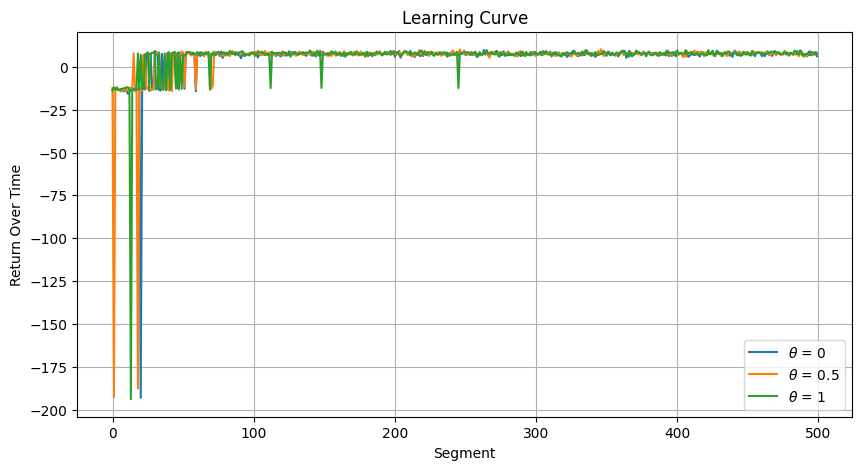

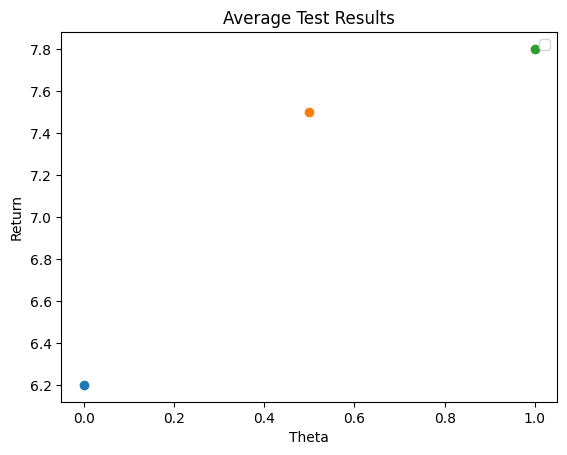

In [16]:
plt.close('all') # clear previous plot
plt.figure(figsize=(10, 5))

alpha = 0.5
temperature= 0.75
thetas = [0, 0.5, 1]

for theta in thetas:
  agent = Hybrid_Sarsa_Q(env, alpha, gamma, temperature, theta)

  print(f"running agent {agent.name()} with theta = {theta}")

  exploration_result, \
  test_result, \
  min_return_during_explore,\
  max_return_during_explore,\
  min_return_during_test,\
  max_return_during_test,\
  learning_curve = experiment(agent)

  plt.figure(1)
  plt.plot(range(NUM_SEGMENTS), learning_curve, label=f"$\\theta$ = {theta}")

  plt.figure(2)
  plt.scatter(theta, test_result)

plt.figure(1)
plt.legend()
plt.title("Learning Curve")
plt.xlabel("Segment")
plt.ylabel("Return Over Time")
plt.grid(True)

plt.figure(2)
plt.title("Average Test Results")
plt.xlabel("Theta")
plt.ylabel("Return")

## Results & Discussion
The result above are consistent with our hypothesis.

First, for $\theta$ = 0 (pure Q-learning), the learning curve quickly stabilizes, which is indicative of lower variance in the returns over segments. This is consistent with Q-learning's nature, which tends to be more stable but potentially biased due to its max operator in the Q-update step. For θ = 1 (pure Expected SARSA), there is a higher variance in the learning curve, and it takes longer for the learning to stabilize. Expected SARSA considers the expected value over all possible actions, leading to a policy that accounts for the actual policy being followed, hence the higher variance from the more exploratory nature and longer convergence time.

Additionally, the test results indicate that the average return increases with θ. This suggests that integrating the Expected SARSA component (accounting for the expected value under the current policy) helps the model achieve a higher return, potentially because it is less prone to the maximization bias inherent in Q-learning's max operator and benefits from a more accurate expectation of future rewards.